## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [153]:
MIN = False

In [179]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

In [180]:
classification_labels

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,

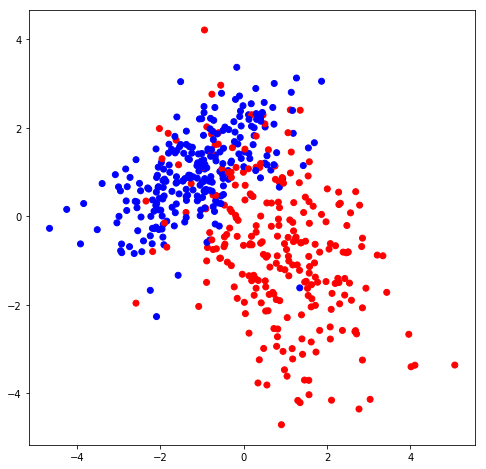

In [181]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [182]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [183]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [184]:
# Реализуем класс узла

class Node:    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        quality, t, index = find_best_split(data, labels)
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.q = quality
        print('q=',quality)
        self.true_branch = None  # поддерево, удовлетворяющее условию в узле
        self.false_branch = None  # поддерево, не удовлетворяющее условию в узле

    def Add(self):
        true_data, false_data, true_labels, false_labels = split(self.data, self.labels, self.index, self.t)
        node1 = Node(true_data, true_labels)  
        if (node1.q == 0):
            self.true_branch = Leaf(true_data, true_labels)
        else:
            self.true_branch = node1
        node2 = Node(false_data, false_labels)  
        if (node2.q == 0):        
            self.false_branch = Leaf(false_data, false_labels)
        else:
            self.false_branch = node2
       
        return self.true_branch, self.false_branch

    def Add_Leaf(self):
        true_data, false_data, true_labels, false_labels = split(self.data, self.labels, self.index, self.t)
        self.true_branch = Leaf(true_data, true_labels)        
        self.false_branch = Leaf(false_data, false_labels)

In [185]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [186]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [187]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [188]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [189]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

Теперь добавим функцию формирования случайного леса.

1) сделать словарь dist где ключи index-индексы а значения - частота
2) найти ключ-индекс с минимальной частотой
3) node с таким индексом больше не добавляй а заверши листом

In [190]:
def get_min(dict_indexes_rate):
    if MIN:
    #прекращаем рост самых редких деревьев    
        min_count = 10**10
        for index,count in dict_indexes_rate.items():
            if count < min_count:
                min_count = count
    else:
    #прекращаем рост супер-редчайших деревьев в 1 экземпляре    
        min_count = 1
    #вычисление средней частоты по больнице
    avg_count = sum(dict_indexes_rate.values())/len(dict_indexes_rate.keys())
    if min_count < avg_count:
        print(avg_count)
        return min_count
    else:
        print('dfdffdfdfd',avg_count)        
        return 10**10 #все равномерно и нет перевеса-тенденции-тренда в определенную сторону 

In [191]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        node = Node(b_data, b_labels)
        forest.append(node)
    lst1 = forest

    min_index = 1
    while True:
        dict_indexes_rate = {} #сделать словарь dist где ключи index-индексы а значения - частота    
        lst2 = []
        for node in lst1:
            if isinstance(node,Node):
                if node.index in dict_indexes_rate:
                    dict_indexes_rate[node.index] += 1
                else:
                    dict_indexes_rate[node.index] = 1
        min_count = get_min(dict_indexes_rate) #найти ключ-индекс с минимальной частотой            
        for node in lst1:
            if isinstance(node,Node):
                if dict_indexes_rate[node.index] == min_count:
                    node.Add_Leaf() #node с таким индексом больше не добавляй а заверши листом
                else:
                    node1, node2 = node.Add()
                    if isinstance(node1,Node):
                        lst2.append(node1)
                    if isinstance(node2,Node):         
                        lst2.append(node2)            
        if lst2 == []:
            break
        lst1 = lst2    
    return forest

In [192]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [193]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [194]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [195]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [196]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [197]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)
for node in my_forest_1:
    print(node.true_branch)
    print(node.false_branch)

q= 0.020331623091003455
dfdffdfdfd 1.0
q= 0.21182833214065303
q= 0.10493827160493831
2.0
q= 0.09421667843924866
q= 0.11772854148935197
q= 0
q= 0
dfdffdfdfd 1.0
q= 0.09851473094716334
q= 0.03686745346480704
q= 0.045490365999401115
q= 0.4501385041551245
4.0
q= 0.07511111111111102
q= 0
q= 0.375
q= 0.01785569353136921
q= 0.004810264950881646
q= 0.49704142011834324
q= 0
q= 0
1.25
q= 0.0009322247417485
q= 0.4444444444444444
q= 0
q= 0
dfdffdfdfd 1.0
q= 0
q= 0.12444444444444439
q= 0
q= 0
dfdffdfdfd 1.0
q= 0
q= 0


In [198]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [199]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [200]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 90.857


In [201]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 88.000


IndexError: index 2 is out of bounds for axis 0 with size 2

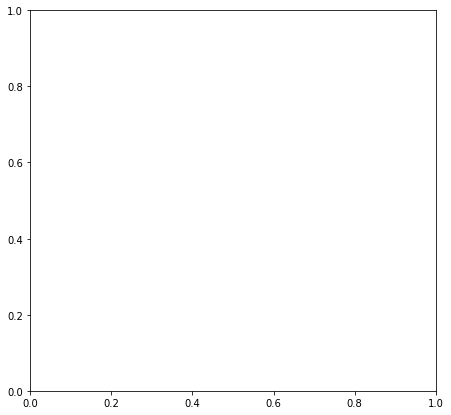

In [202]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из трех деревьев

In [203]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

q= 0.19851066793815159
q= 0.20407039978552996
q= 0.16286821208643332
1.5
q= 0.11227884324016235
q= 0.04270927187435282
q= 0.06352357124641722
q= 0.15375282098570692
2.0
q= 0.15917107583774254
q= 0.010111010817890731
q= 0.0029391994091082126
q= 0.20663265306122458
q= 0
q= 0.022436745388307325
q= 0
q= 0.05668934240362809
2.0
q= 0.20833333333333331
q= 0.06122448979591835
q= 0.055188812997776365
q= 0.04374432516156604
q= 0.13265306122448978
q= 0.21768707482993196
q= 0.014692378328741866
q= 0.12934618291761155
q= 0.23999953125091555
q= 0.13265306122448978
2.5
q= 0.4444444444444445
q= 0
q= 0.5
q= 0
q= 0
q= 0.010941181206210317
q= 0
q= 0
q= 0
q= 0.4444444444444445
q= 0.10578512396694234
q= 0
q= 0.2514029180695847
q= 0.079861111111111
q= 0.0623078111720623
q= 0
q= 0
q= 0
1.6
q= 0
q= 0
q= 0
q= 0
q= 0.021038062283737002
q= 0.4444444444444445
q= 0
q= 0
dfdffdfdfd 1.0
q= 0.1777777777777778
q= 0
q= 0
q= 0
dfdffdfdfd 1.0
q= 0.48
q= 0
dfdffdfdfd 1.0
q= 0
q= 0


In [204]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [205]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [206]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 93.429


In [207]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 90.000


IndexError: index 2 is out of bounds for axis 0 with size 2

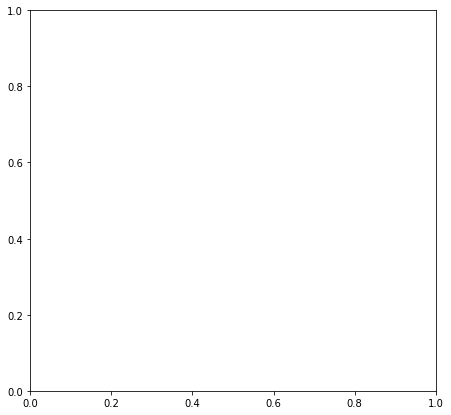

In [208]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из десяти деревьев

In [209]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

q= 0.19665862129113365
q= 0.17013888888888895
q= 0.20254624617380432
q= 0.17482723677893036
q= 0.17196243714877263
q= 0.1832711044641234
q= 0.1915842417102665
q= 0.1769641133480419
q= 0.17836043349901062
q= 0.20741724928113647
3.3333333333333335
q= 0.03098076642259623
q= 0.09624763201011524
q= 0.06193000002034327
q= 0.1430017786359134
q= 0.11170352520012226
q= 0.1310402068954984
q= 0.03571408329365891
q= 0.21101877325143684
q= 0.10170153368547864
q= 0.268534754064483
q= 0.06266307886089986
q= 0.1766398521613935
q= 0.10980343083185823
q= 0.14938457328363153
q= 0.03229980468749993
q= 0.18609745524159937
q= 0.07513716521356194
q= 0.05270251561571104
3.6
q= 0
q= 0.01618060832877094
q= 0.07265275784861566
q= 0.07077791715583004
q= 0.23111111111111104
q= 0.10045053071855867
q= 0.01379071864318409
q= 0.25920000000000004
q= 0.08465677179962906
q= 0.020499035580908737
q= 0.0132612367736136
q= 0.40816326530612246
q= 0.1875
q= 0.015565884769214194
q= 0.0004120756069156753
q= 0.33207401583973917
q

In [210]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [211]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [212]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.143


In [213]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 96.000


IndexError: index 4 is out of bounds for axis 0 with size 2

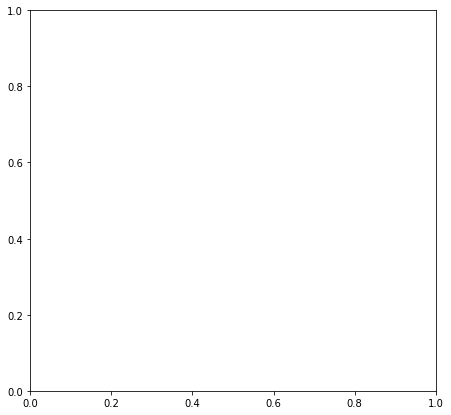

In [214]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из пятидесяти деревьев

In [215]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

q= 0.19904513675459345
q= 0.18613722090885218
q= 0.2168719732196676
q= 0.183449435496166
q= 0.2092938862307283
q= 0.17258115246098443
q= 0.18602254428341397
q= 0.19440178578960862
q= 0.18830577885178124
q= 0.16182871464375215
q= 0.1777777777777778
q= 0.19064483635974067
q= 0.20688048398037612
q= 0.1955116883116882
q= 0.2018716619014756
q= 0.17306417531365265
q= 0.18529247679367303
q= 0.20391276629387245
q= 0.19888527895994898
q= 0.14599688858815082
q= 0.16432185559791448
q= 0.025442155078267054
q= 0.18880398045294064
q= 0.2239626403731923
q= 0.1698612244897959
q= 0.22683304910320498
q= 0.2236095288521098
q= 0.02117331158168606
q= 0.19042857870420893
q= 0.16872362504323773
q= 0.21506834937020486
q= 0.12267371977555822
q= 0.2073275264745073
q= 0.2174876932591219
q= 0.20063514852980074
q= 0.15451115590596276
q= 0.007107953081564859
q= 0.18872941844653318
q= 0.1515424637249928
q= 0.02678450584703629
q= 0.1459551775004691
q= 0.2106988756793039
q= 0.21160258963488776
q= 0.035102620987533084


q= 0.08546181914098555
q= 0.02272427004888362
q= 0.31031932258722716
q= 0
q= 0.11885625115519141
q= 0
q= 0
q= 0.14222222222222203
q= 0.12705882352941167
q= 0.042483660130718914
q= 0
q= 0
q= 0.0037182280319536833
q= 0.1866666666666665
q= 0.026288105957693708
q= 0
q= 0
q= 0
q= 0
q= 0.345679012345679
q= 0.005983015496757713
q= 0
q= 0
q= 0.04613129580539532
q= 0
q= 0.111111111111111
q= 0.31999999999999984
q= 0.0013286564625849817
q= 0.4444444444444445
q= 0
q= 0.03687009742923234
q= 0
q= 0.17777777777777792
q= 0.06887755102040809
q= 0.18145161290322576
q= 0.009339417773581597
q= 0.2777777777777777
q= 0.023228972310045264
q= 0
q= 0.0032598193656794977
q= 0.04958677685950419
q= 0.27317593704148335
q= 0
q= 0
q= 0.058788724370790635
q= 0.08928571428571425
q= 0.006707702020202086
q= 0.09122474747474735
q= 0.5
q= 0
q= 0.24574829931972791
q= 0.002732580866231217
q= 0.1171875
q= 0.001468572297865206
q= 0
q= 0
q= 0.156064209274673
q= 0.027772267407260447
q= 0.48
q= 0.01185233960245266
q= 0.018204158

q= 0.35189762978042755
q= 0
q= 0
q= 0.18019703204888377
q= 0
q= 0
q= 0
q= 0.10493827160493831
q= 0.05892674964293007
q= 0.024817038844060862
q= 0
q= 0.5
q= 0.11523809523809514
q= 0.2777777777777777
q= 0.25
q= 0
q= 0
q= 0.028925619834710842
q= 0.2603550295857988
q= 0
q= 0.1799816345270891
q= 0
q= 0.11051020408163253
q= 0.0005572775135869717
q= 0
q= 0
q= 0.08197887905268847
q= 0.007200000000000102
q= 0
q= 0.345679012345679
q= 0.03454693877551028
q= 0
q= 0.2350780532598714
q= 0.21875
q= 0.05442176870748308
q= 0
q= 0.05741464243247829
q= 0.16875
q= 0.027517522428963284
q= 0.375
q= 0
q= 0.11666216581150404
q= 0.4444444444444445
q= 0
q= 0
q= 0.3173553719008265
q= 0.0989720957253426
q= 0
q= 0
q= 0.41156462585034015
q= 0.375
q= 0
q= 0
q= 0.375
q= 0
q= 0
q= 0.5
q= 0
q= 0
q= 0.0034920634920635046
q= 0.007838526357045017
q= 0.005293577486090738
q= 0
q= 0
q= 0.4444444444444445
q= 0
q= 0
q= 0
q= 0.1527777777777779
q= 0.03443526170798894
q= 0.019984210254480467
q= 0.375
q= 0
q= 0
q= 0.40816326530612

q= 0.03082899826597313
q= 0
q= 0
q= 0.022050000000000125
q= 0
q= 0.5
q= 0.375
q= 0
q= 0.24489795918367355
q= 0.0005661480020454322
q= 0
q= 0
q= 0.01901944209636519
q= 0.111111111111111
q= 0.03537266605448422
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
44.8
q= 0
q= 0
q= 0.15277777777777787
q= 0
q= 0
q= 0.4444444444444445
q= 0
q= 0
q= 0.2688888888888889
q= 0.48
q= 0.4444444444444445
q= 0
q= 0
q= 0
q= 0.11111111111111102
q= 0
q= 0
q= 0
q= 0.07999999999999996
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0.12188365650969524
q= 0.07999999999999993
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0
q= 0.21333333333333332
q= 0.375
q= 0
q= 0
q= 0.08730158730158721
q= 0.5
q= 0
q= 0
q= 0.11111111111111116
q= 0.375
q= 0.046666666666666606
q= 0
q= 0
q= 0
q= 0.0862633900441083
q= 0
q= 0
q= 0
q= 0.31999999999999984
q= 0.20166666666666655
q= 0
q= 0
q= 0
q= 0.48
q= 0.11999999999999983
q= 0
q= 0
q= 0
q= 0.09142857142857119
q= 0.22222222222222227
q= 0
q= 0
q= 0.48
q= 0
q= 0.5
q= 0.444444444444444

In [217]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [218]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [219]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [220]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


IndexError: index 4 is out of bounds for axis 0 with size 2

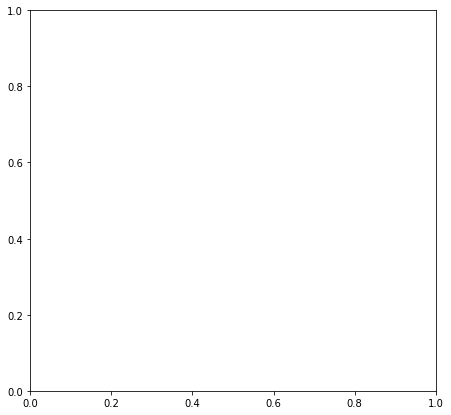

In [221]:
# Визуализируем дерево на графике

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Домашнее задание

1. Сформировать с помощью `sklearn.make_classification` датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. (*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.